# Hotel Demand Project
## Team: 5
Christian Rose, JP Aspinwall, Zehao Dong, Jingda Xu

Problem Statement
Given that there is a large number of variables that can present themselves in booking a hotel, with the overall goal being to tradeoff comfort and cost. In order to do this, we’d propose using the above dataset to build a model which predicts the lowest possible cost of stay and the way in which to achieve that cost (based on how the stay is booked and characteristics of the stay such as # of nights and country).

# Hotel Demand

**Data Source:**https://www.kaggle.com/jessemostipak/hotel-booking-demand

**Context:**
Have you ever wondered when the best time of year to book a hotel room is? Or the optimal length of stay in order to get the best daily rate? What if you wanted to predict whether or not a hotel was likely to receive a disproportionately high number of special requests?

**Dataset used for Analysis:** 

Dataset Definition

**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|hotel|H1 = Resort Hotel or H2= City Hotel|Categorical|
|is_canceled|0 not 1 canceled|Boolean|
|lead_time|Number of days that elapsed between the entering date of the booking into the PMS and the arrival date|Integer|
|arrival_date_yer|Year of arrival date|string|
|arrival_date_month|Month of arrival date|string|
|arrival_date_week_number|Week numbber of yaer for arrival|Integer|
|arrival_date_day_of_month|Day of arrival date|Integer|
|stays_in_weekend_nights|number of weekend nights (saturday or sunday) the guest stays at the hotel|Integer|
|stays_in_week_nights|number of week nights (Monday to Friday) the guest stays at the hotel|Integer|
|adults|number of adults|Integer|
|childern|number of children|Integer|
|babdies|number of babies|Integer|
|meal|Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)|Categorical|
|country|Country of origin. Categories are represented in the ISO 3155–3:2013 format|string|
|market_segment|Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”|Categorical|
|distribution_channel|Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”|Categorical|
|is_repeated_guest|Value indicating if the booking name was from a repeated guest (1) or not (0)|Boolean|
|previous_cancellations|Number of previous bookings that were cancelled by the customer prior to the current booking|Integer|
|previous_bookings_not_canceled|Number of previous bookings not cancelled by the customer prior to the current booking|Integer|
|reserved_room_type|Code of room type reserved. Code is presented instead of designation for anonymity reasons.|Categorical|
|assigned_room_type|Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.|Categorical|
|booking_changes|Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|Integer|
|deposit_type|Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.|Categorical|
|agentID| of the travel agency that made the booking|String|
|companyID| of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons|String|
|days_in_waiting_list|Number of days the booking was in the waiting list before it was confirmed to the customer customer_type|Integer|
|Type of booking|, assuming one of four categories:Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking|Categorical|
|adrAverage| Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights|Numerical|
|required_car_parking_spaces|Number of car parking spaces required by the customer|Integer|
|total_of_special_requests|Number of special requests made by the customer (e.g. twin bed or high floor)|Integer|
|reservation_status|Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why|Categorical|
|reservation_status_date|Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel|Categorical|


In [ ]:
!conda install scikit-learn
!conda install pandas
!conda install seaborn
!conda install statsmodels

In [75]:
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression as pslr
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder as pgb
from pyspark.ml.tuning import TrainValidationSplit as ptvs
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import statsmodels.api as sm

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_fscore_support as score

### Config Data File Paths

In [3]:
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
data = "gs://" + bucket + "/notebooks/jupyter/data/"
print(data)

gs://is843_cr_proj/notebooks/jupyter/data/


In [4]:
hotel_data = spark.read.format("csv")\
         .option("header", "true")\
         .option("inferSchema", "true")\
         .option("nullValue", "NULL")\
         .load(data + "hotel_bookings.csv")

# Print the Schema of loaded hotel dataset
hotel_data.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

the default type of column 'children' is string, we need to change it to integer

In [5]:
hotel_data = hotel_data.withColumn("children", hotel_data["children"].cast(IntegerType()))

In [6]:
# save the original data and cash the dataframe
hotel_backup = hotel_data
hotel_data.cache()

DataFrame[hotel: string, is_canceled: int, lead_time: int, arrival_date_year: int, arrival_date_month: string, arrival_date_week_number: int, arrival_date_day_of_month: int, stays_in_weekend_nights: int, stays_in_week_nights: int, adults: int, children: int, babies: int, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: int, previous_cancellations: int, previous_bookings_not_canceled: int, reserved_room_type: string, assigned_room_type: string, booking_changes: int, deposit_type: string, agent: int, company: int, days_in_waiting_list: int, customer_type: string, adr: double, required_car_parking_spaces: int, total_of_special_requests: int, reservation_status: string, reservation_status_date: timestamp]

### Number of rows

In [9]:
# Print number of records in the dataset. 
print("Number of rows in the dataset {}".format(hotel_data.count()))

Number of rows in the dataset 119390


### Checking for missing data

Count the number of nulls in each column of the dataset

In [10]:
[(c, hotel_data.where(col(c).isNull()).count()) for c in hotel_data.columns]

[('hotel', 0),
 ('is_canceled', 0),
 ('lead_time', 0),
 ('arrival_date_year', 0),
 ('arrival_date_month', 0),
 ('arrival_date_week_number', 0),
 ('arrival_date_day_of_month', 0),
 ('stays_in_weekend_nights', 0),
 ('stays_in_week_nights', 0),
 ('adults', 0),
 ('children', 4),
 ('babies', 0),
 ('meal', 0),
 ('country', 488),
 ('market_segment', 0),
 ('distribution_channel', 0),
 ('is_repeated_guest', 0),
 ('previous_cancellations', 0),
 ('previous_bookings_not_canceled', 0),
 ('reserved_room_type', 0),
 ('assigned_room_type', 0),
 ('booking_changes', 0),
 ('deposit_type', 0),
 ('agent', 16340),
 ('company', 112593),
 ('days_in_waiting_list', 0),
 ('customer_type', 0),
 ('adr', 0),
 ('required_car_parking_spaces', 0),
 ('total_of_special_requests', 0),
 ('reservation_status', 0),
 ('reservation_status_date', 0)]

There are NULL values in 'children', 'country', 'company', and 'agent'. Agent only has 3 non null values that have more than 5% of the total volume of records. 94% of the values in Company are Null.

### Dropping rows with 0 or less than 0 average daily rate
Within the dataset there are 1960 rows where there is an average daily rate of 0.  Our reasonable assumption is that when you book for a hotel room you'll be paying for it.  As such, we'll remove these records from our dataset as part of our pre-processing

In [7]:
hotel_data=hotel_data.where(col('adr')>0)
hotel_data.count()

117430

### Data Pre-Processing and some Analysis

The company column has a low coverage (112k missing values).  This will introduce a lot of noise into our modelling so we'll drop the column.

Additionally, we'll correct the null values within the dataset, setting the null children records to be 0 and fill the rows with missing country values as No Country

In [2]:
hotel_pd = hotel_data.toPandas()
#hotel_pd = pd.read_csv("hotel_bookings.csv", header='infer')
hotel_pd = hotel_pd.drop(['company'], axis = 1)
hotel_pd[['children']] = hotel_pd[['children']].fillna(value=0)
hotel_pd[['country']] = hotel_pd[['country']].fillna(value='No_Country')
hotel_pd[['agent']] = hotel_pd[['agent']].fillna(value='0')
len(hotel_pd.index)

117430

Our data isn't super friendly to doing any sort of machine based processing and modelling, so in order to support this, we'll need to do a few things

- Convert all text based categorical values to numerical
- Convert dates to be numerical rather than string

In [3]:
label_encoder = LabelEncoder() 
  
# Encode labels in column. 
hotel_pd['customer_type']= label_encoder.fit_transform(hotel_pd['customer_type']) 
hotel_pd['assigned_room_type'] = label_encoder.fit_transform(hotel_pd['assigned_room_type'])
hotel_pd['reservation_status'] = label_encoder.fit_transform(hotel_pd['reservation_status'])
hotel_pd['meal'] = label_encoder.fit_transform(hotel_pd['meal'])
hotel_pd['country'] = label_encoder.fit_transform(hotel_pd['country'])
hotel_pd['distribution_channel'] = label_encoder.fit_transform(hotel_pd['distribution_channel'])
hotel_pd['market_segment'] = label_encoder.fit_transform(hotel_pd['market_segment'])
hotel_pd['reserved_room_type'] = label_encoder.fit_transform(hotel_pd['reserved_room_type'])
hotel_pd['reservation_status_date'] = label_encoder.fit_transform(hotel_pd['reservation_status_date'])

hotel_pd['hotel'] = hotel_pd['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

hotel_pd['arrival_date_month'] = hotel_pd['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

Next, we define some functions to flag if the booking is for more than one individual or a single guest

In [4]:
def family(df):
    if ((df['adults'] > 0) & ((df['children'] > 0)|(df['babies'] > 0))):
        val = 1
    else:
        val = 0
    return val

We'll next convert the deposit column into two labels

- If it costs the customer nothing to cancel the reservation - Refundable or No Deposit given
- If it costs the customer something to cancel aka non-refundable

In [5]:
def deposit(df):
    if ((df['deposit_type'] == 'No Deposit') | (df['deposit_type'] == 'Refundable')):
        return 0
    else:
        return 1

Looking closer at the agent column, we can see an overrepresentation of a few agents within the dataset.  There are 330 distinct agents along with a no agent (null) representation in the dataset.

Text(0.5, 0, 'Agent')

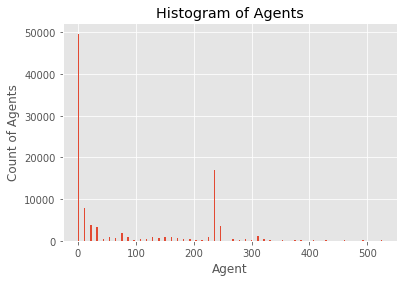

In [39]:
agent_hist = hotel_data.select(col("agent"))\
    .rdd.flatMap(
        lambda row: row
    ).histogram(50)

data = {
    'bins': agent_hist[0][:-1],
    'freq': agent_hist[1]
}

plt.bar(data['bins'], data['freq'], width = 2.5 )
plt.title('Histogram of Agents')
plt.ylabel("Count of Agents")
plt.xlabel("Agent")

To ensure that agent doesn't have an adverse impact on our modelling we'll look to group the data. Three of the agents capture the largest share of the bookings along with no agent used, we'll account for that by grouping the data.  This will reduce fragmentation later down the line during our modelling

In [6]:
def agent_clean(df):
    if ((df['agent']!=1)|(df['agent']!=9)|(df['agent']!=240)|(df['agent']!=0)):
        val = 4
    if (df['agent'] == 9):
        val = 1
    if (df['agent'] == 240):
        val = 2
    if (df['agent'] == 1):
        val = 3
    return val

Apply the functions we defined above

In [7]:
def transform_data(df):
    df["is_family"] = df.apply(family, axis = 1)
    df["total_customer"] = df["adults"] + df["children"] + df["babies"]
    df["deposit_given"] = df.apply(deposit, axis=1)
    df["total_nights"] = df["stays_in_weekend_nights"]+ df["stays_in_week_nights"]
    hotel_pd['agent'] = hotel_pd.apply(agent_clean, axis = 1)
    return df

In [8]:
hotel_pd = transform_data(hotel_pd)

Quick look at our data post processing

In [53]:
hotel_pd

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_family,total_customer,deposit_given,total_nights
0,0,0,80,2017,3,10,5,12,26,2,...,3,0.26,0,0,1,416,0,2.0,0,38
1,1,1,37,2016,2,8,20,4,8,1,...,2,0.50,0,0,0,19,0,1.0,0,12
2,1,1,4,2016,2,9,23,0,2,1,...,2,1.00,0,0,0,293,0,1.0,0,2
3,1,1,116,2016,2,10,28,2,1,1,...,3,1.00,0,0,2,307,0,1.0,0,3
4,1,1,116,2016,2,10,28,2,1,1,...,3,1.00,0,0,2,307,0,1.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117425,0,1,378,2017,8,31,1,4,10,2,...,2,450.00,0,0,0,709,0,2.0,0,14
117426,1,0,81,2016,12,53,31,1,1,2,...,3,451.50,0,4,1,25,1,4.0,0,2
117427,0,0,1,2015,7,29,15,0,1,2,...,2,508.00,1,0,1,687,0,2.0,0,1
117428,1,0,0,2017,5,19,9,0,1,1,...,2,510.00,0,0,1,496,0,1.0,0,1


Cleanup the columns we've transformed to more modelling friendly labels prior to starting our modelling

In [9]:
hotel_pd = hotel_pd.drop(columns = ['adults', 'babies', 'children', 'deposit_type', 'reservation_status_date'])

Finally, cleanup any data that's left over which is null, 0 records but a good safety valve

In [10]:
hotel_pd = hotel_pd.dropna(axis = 0)

In [11]:
len(hotel_pd.index)

117430

Now that we've cleanse our dataset we'll take a closer look at the correlation within the dataset

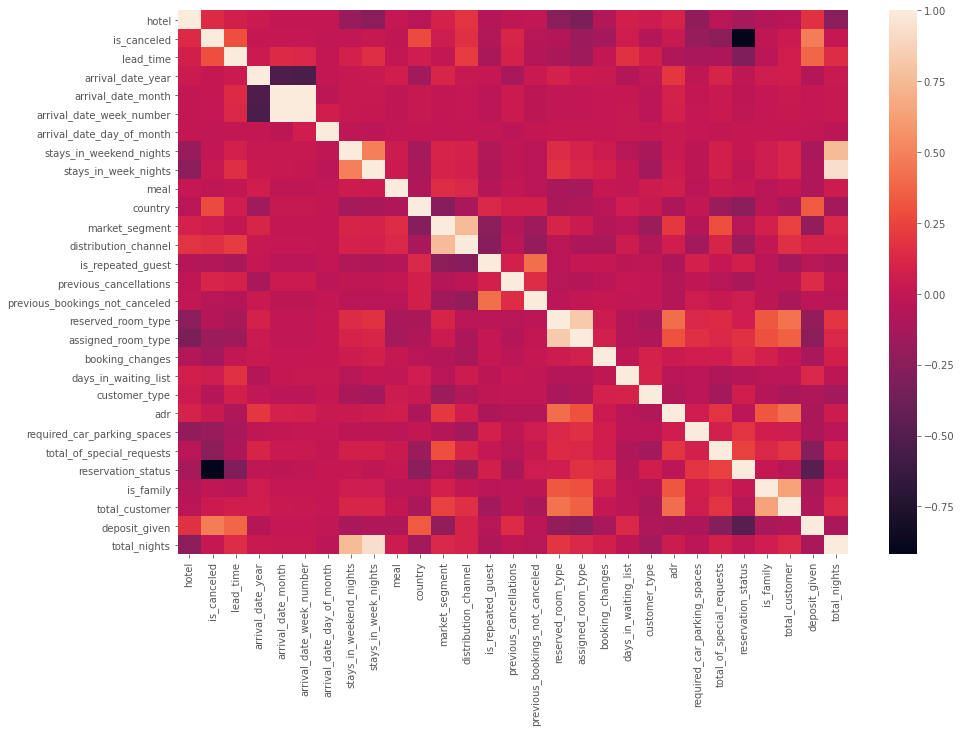

In [29]:
corr=hotel_pd.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)
plt.show()

# Modeling

## Predicting ADR Using a Linear Regression

Our first model is linear and attempts to predict the average daily rate. We start by printing a correlation matrix to determine the significance of each variable

Looking more closely at the correlation values for ADR to see where the predictive power of the model might come from.

We can see that total customers, room type, and whether or not the booking is for a family have high correlation with a higher ADR 

In [30]:
np.abs(corr).adr.sort_values(ascending=False)

adr                               1.000000
total_customer                    0.413555
reserved_room_type                0.412846
is_family                         0.319254
assigned_room_type                0.306163
market_segment                    0.202866
arrival_date_year                 0.195525
total_of_special_requests         0.180939
deposit_given                     0.103853
country                           0.100305
is_repeated_guest                 0.098120
hotel                             0.097482
arrival_date_month                0.087403
lead_time                         0.086964
arrival_date_week_number          0.083721
customer_type                     0.077245
distribution_channel              0.069900
previous_cancellations            0.067797
meal                              0.063606
previous_bookings_not_canceled    0.060894
required_car_parking_spaces       0.058011
total_nights                      0.046900
stays_in_week_nights              0.045408
days_in_wai

choose some resonable variables as independent variables to do the linear regression, and we first create train and test set

In [42]:
X = hotel_pd[['reserved_room_type', 
              'total_customer', 
              'is_family', 
              'assigned_room_type', 
              'arrival_date_year', 
              'market_segment',
              'total_of_special_requests',
              'deposit_given',
              'lead_time',
              'country',
              'is_repeated_guest']]
y = hotel_pd[['adr']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=843)

In [43]:
#Now we can create the linear model
X_train = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train)

In [44]:
#Next we fit the model and get the summary
Fitted_ols = ols.fit()
Fitted_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    adr   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2900.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:59:19   Log-Likelihood:            -4.2523e+05
No. Observations:               82201   AIC:                         8.505e+05
Df Residuals:                   82189   BIC:                         8.506e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.981e+04    435.596    -45.475      0.000   -2.07e+04    -1.9e+04
reserved_room_type           10.4820      0.167     62.827      0.000      10.155      10.809
total_customer               16.6835      0.333     50.102      0.000      16.031      17.336
is_family                    13.1305      0.745     17.625      0.000      11.670      14.591
assigned_room_type           -3.1036      0.151    -20.514      0.000      -3.400      -2.807
arrival_date_year             9.8493      0.216     45.588      0.000       9.426      10.273
market_segment                3.2168      0.137     23.527      0.000       2.949       3.485
total_of_special_requests     3.9849      0.204     19.529      0.000       3.585       4.385
deposit_given                 7.1895      0.545     13.183      0.000       6.121       8.258
lead_time                    -0.0477      0.002    -30.872      0.000      -0.051      -0.045
country                       0.0073      0.004      2.005      0.045       0.000       0.014
is_repeated_guest           -12.7999      0.954    -13.419      0.000     -14.669     -10.930
==============================================================================
Omnibus:                   197481.628   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      28442214498.065
Skew:                          23.716   Prob(JB):                         0.00
Kurtosis:                    2884.310   Cond. No.                     5.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R squared of this model is very low, so it may not be appropriate to use the linear model fit the data, we use this model to predict on test set and compare the result

In [45]:
X_test = sm.add_constant(X_test)
y_pred = Fitted_ols.predict(X_test)
print('mean squared error:', np.mean((y_test.values.flatten() - y_pred)**2))

mean squared error: 1482.9577835344787


Conclusion:from the MSE we can see the model is not so good

## Decision Tree Regression To Predict ADR

Setup the model

In [68]:
supervised = RFormula(formula="adr ~ .")
fittedRF = supervised.fit(df)  # fit the transformer
preparedDF = fittedRF.transform(df)  # transform

In [69]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,hotel
1,is_canceled
2,lead_time
3,arrival_date_year
4,arrival_date_month


Define Test/Train Split

In [70]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)

In [74]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(train)

Predict ADR

In [76]:
#get features after applying trasnformation
dt_predictions = dt_model.transform(test)

# Select example rows to display.
dt_predictions.select("prediction", "label", "features").show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 95.18944216529921|123.0|(35,[3,4,5,6,8,9,...|
|122.35113785361435|117.9|(35,[3,4,5,6,8,9,...|
|180.27408026755856|195.0|(35,[3,4,5,6,8,9,...|
|194.27730106100796|150.0|(35,[3,4,5,6,7,8,...|
| 95.18944216529921|134.0|(35,[3,4,5,6,8,9,...|
+------------------+-----+--------------------+
only showing top 5 rows



ADR Cannot be reliably predicted leveraging the features we have in this dataset.  Althought this model performs significantly beter than our logistic regression model, it still lacks statistical signficance.

In [77]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute rmse for test set
dt_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Decision tree approach Root Mean Squared Error (RMSE) on test data = %g" % rmse)

dt_evaluator2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator2.evaluate(dt_predictions)
print("Decision tree approach R Square on test data = %g" % r2)

Decision tree approach Root Mean Squared Error (RMSE) on test data = 32.8732
Decision tree approach R Square on test data = 0.511064


## Modelling to Predict Whether or Not a Reservation Could Be Cancelled

We spent a fair bit of time trying to build and tune a model that could predict the ADR, however the results were all uninspiring.  The first model was one of our better results, as such we took a look at the dataset against and started to work towards predicting whether a reservation would be cancelled or not.

## Modelling Is Cancelled Going Overboard

In [57]:
labels = hotel_pd[["is_canceled"]]
ind = hotel_pd.drop(["is_canceled"], axis = 1)

ind_train, ind_test, labels_train, labels_test = train_test_split(ind, labels, test_size = 0.30, random_state = 737)

Define a basic Decision Tree model

In [58]:
canceled_dt = DecisionTreeClassifier(max_depth = 10)
canceled_dt_model = canceled_dt.fit(ind_train, labels_train) 
labels_pred = canceled_dt_model.predict(ind_test)

In [59]:
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(labels_test,labels_pred), confusion_matrix(labels_test,labels_pred), roc_auc_score(labels_test,labels_pred)))

Decision Tree Model
Accuracy Score: 1.0

Confusion Matrix:
 [[22008     0]
 [    0 13221]]

AUC Score: 1.0


Given a perfect performance it's pretty easy to deduce our model is either overfitted or something is wrong with the model.  Looking at the strong correlation between reservation status and cancellation would indicate that to be true

In [60]:
corr["is_canceled"].sort_values()

reservation_status               -0.918026
total_of_special_requests        -0.237306
required_car_parking_spaces      -0.197504
assigned_room_type               -0.172597
booking_changes                  -0.144828
is_repeated_guest                -0.074563
customer_type                    -0.067508
reserved_room_type               -0.062360
previous_bookings_not_canceled   -0.054862
meal                             -0.017644
is_family                        -0.013681
stays_in_weekend_nights          -0.007100
arrival_date_day_of_month        -0.006307
arrival_date_week_number          0.009552
total_nights                      0.011088
arrival_date_month                0.012445
arrival_date_year                 0.014097
stays_in_week_nights              0.018575
adr                               0.030554
total_customer                    0.040282
market_segment                    0.050855
days_in_waiting_list              0.054126
previous_cancellations            0.110671
hotel      

In [12]:
hotel_pd2 = hotel_pd.drop(["reservation_status"], axis=1)
labels = hotel_pd2[["is_canceled"]]
ind = hotel_pd2.drop(["is_canceled"], axis = 1)

ind_train, ind_test, labels_train, labels_test = train_test_split(ind, labels, test_size = 0.30, random_state = 737)

In [62]:
canceled_dt = DecisionTreeClassifier(max_depth = 10)
canceled_dt_model = canceled_dt.fit(ind_train, labels_train) 
labels_pred = canceled_dt_model.predict(ind_test)

This variation of the model performs reasonably well (and realistically given we've removed the hindsight of knowing the reservation was cancelled) with a performance of 83%

In [63]:
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(labels_test,labels_pred), confusion_matrix(labels_test,labels_pred), roc_auc_score(labels_test,labels_pred)))

Decision Tree Model
Accuracy Score: 0.8449572795140368

Confusion Matrix:
 [[20006  2002]
 [ 3460  9761]]

AUC Score: 0.8236641077028161


k-Fold Cross Validation Definition - https://machinelearningmastery.com/k-fold-cross-validation/

tl;dr we resample the dataset into k folds and recreate the same train/test fit (70/30 in our case) then re-train and re-test the model using this data.  We look for the results of the validation to be as close as possible to our model trained using the full dataset.  If the value is substantially lower, that implies our dataset used to build the model created an overfitted model

In [64]:
scores = cross_val_score(canceled_dt_model, ind_train, labels_train, cv = 5)
print("cross validation scores: {}".format(scores))
print("mean cross validation score: {}".format(np.mean(scores)))
print("score without cv: {}".format(canceled_dt_model.score(ind_train, labels_train)))

cross validation scores: [0.85438842 0.84823601 0.84768856 0.85006083 0.84835766]
mean cross validation score: 0.8497462969778686
score without cv: 0.853335117577645


Based on the precision, recall, fscore, and support we can see that the predictions are performing much better on the reservations not canceled class rather than the canceled reservation class.  Based on this, we should see if we can bring some paridy to the model and get a stronger classification for predicting whether a reservation will be cancelled.

These numbers overall support a pretty good model

Precision and Recall Definitions
https://en.wikipedia.org/wiki/Precision_and_recall

General Definitions
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [65]:
precision, recall, fscore, support = score(labels_test, labels_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.85255263 0.82980532]
recall: [0.90903308 0.73829514]
fscore: [0.87988741 0.78138008]
support: [22008 13221]


We can see that the whether a deposit is given is the leading indicator of whether or a reservation is canceled or not.  This lines up with our correlation data almost identically

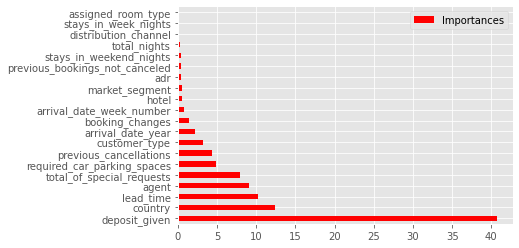

In [66]:
pd.DataFrame(data = canceled_dt_model.feature_importances_*100,
                   columns = ["Importances"],
                   index = ind_train.columns).sort_values("Importances", ascending = False)[:20].plot(kind = "barh", color = "r")

## Build out a grid search to play with the decision tree parameters

Now that we've identified a reasonable feature set, lets see if we can improve the model performance

The following parameters are available for tuning in the Decision tree https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [13]:
param_grid = {'criterion':['gini','entropy'],
             'max_depth':[1,2,3,5,6,7,8,9,10,11,12,13,14,15,21],
             'splitter':['best','random'],
             'min_samples_leaf':[1,2,3,5,8,13,21],
             'max_features': ['auto', 'sqrt', 'log2', None]}

In [14]:
canceled_dt = GridSearchCV(DecisionTreeClassifier(), param_grid)
canceled_dt.fit(ind_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [15]:
pred = canceled_dt.predict(ind_test)
labels_pred = canceled_dt.predict_proba(ind_test)[:, 1]
performance = roc_auc_score(labels_test, pred)
performance

0.8432025914293022

There are significant improvements in the overall performance of the model with the hyperparameter tuning.  The false positive classifications has dropped by 670 and we see an uptick in true negatives of ~700.  This model performs classifies significantly better than the original decision tree

In [70]:
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(labels_test,pred), confusion_matrix(labels_test,pred), roc_auc_score(labels_test,pred)))

Decision Tree Model
Accuracy Score: 0.8579863180902098

Confusion Matrix:
 [[19794  2214]
 [ 2789 10432]]

AUC Score: 0.8442239726016663


We can see a small degradation for the not canceled class (first column) and a measurable improvement in the model performance for the cancelled class.

In [71]:
precision, recall, fscore, support = score(labels_test, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.87650002 0.82492488]
recall: [0.89940022 0.78904773]
fscore: [0.88780247 0.80658754]
support: [22008 13221]


We validate the overall model using a K-folds cross validation.  We can see minimal degradation of the AUC of the model when applying the cross validation meaning the model is not that overfitted.

In [72]:
scores = cross_val_score(canceled_dt_model, ind_train, labels_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(scores)))
print("score without cv: {}".format(canceled_dt_model.score(ind_train, labels_train)))

mean cross validation score: 0.8500504863960346
score without cv: 0.853335117577645


Here we can see an interesting change in feature importances where deposit given goes down in weight

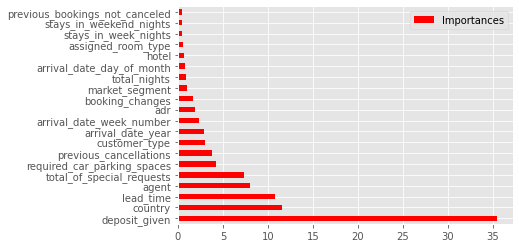

In [73]:
pd.DataFrame(data = canceled_dt.best_estimator_.feature_importances_*100,
                   columns = ["Importances"],
                   index = ind_train.columns).sort_values("Importances", ascending = False)[:20].plot(kind = "barh", color = "r")

We can visualize the decision tree model here

Don't run this code in GCP it'll crash your environment.  We've attached it as part of a separate submission to make things more managable

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)
a = tree.plot_tree(canceled_dt.best_estimator_,
               feature_names = ind_train.columns,
               class_names = ['canceled','not canceled'],
               filled = True)

## Let's try an Unsupervised Model
For this classification we'll leverage a Multi-Layer Preception Classifier (neural network classifier)

In [75]:
scaler = StandardScaler()
scaler.fit(ind_train)
ind_train_scaled = scaler.transform(ind_train)
ind_test_scaled = scaler.transform(ind_test)

In [89]:
canceled_dt = MLPClassifier()
canceled_dt_model = canceled_dt.fit(ind_train_scaled, labels_train)
labels_pred = canceled_dt_model.predict(ind_test_scaled)

C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results look promising, so we'll see if we can hone in on a better model, and this performs about as well as our original decision tree model, but slightly better as the accuracy is marginally higher and is reflected in the confusion matrix with a really low true negative rate.

In [90]:
print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(labels_test,labels_pred), confusion_matrix(labels_test,labels_pred), roc_auc_score(labels_test,labels_pred)))

Accuracy Score: 0.864032473246473

Confusion Matrix:
 [[19837  2171]
 [ 2619 10602]]

AUC Score: 0.8516300558074185


The precision and recall metrics for our second class (canceled reservations) is a bit lower than what we saw out of our decision tree, but overall this model is actually performing quite well

In [91]:
precision, recall, fscore, support = score(labels_test, labels_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.88337193 0.8300321 ]
recall: [0.90135405 0.80190606]
fscore: [0.8922724  0.81572671]
support: [22008 13221]


Can we improve the model any further through tuning the hyper parameters?

In [79]:
param_grid = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001],
              "solver": ["lbfgs", "adam", "sgd"],
              "activation": ["logistic", "relu"],
              "learning_rate": ["constant", "invscaling","adaptive"]}

In [80]:
canceled_dt = MLPClassifier()
canceled_dt_model = GridSearchCV(canceled_dt, param_grid,
                                 cv = 10,
                                 n_jobs = -1,
                                 verbose = 2)
canceled_dt_model = canceled_dt.fit(ind_train_scaled, labels_train)

C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [84]:
labels_pred = canceled_dt_model.predict(ind_test_scaled)

The confusion matrix shows some improvements in the true negatives and false positive classifications

In [87]:
print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(labels_test,pred), confusion_matrix(labels_test,labels_pred), roc_auc_score(labels_test,labels_pred)))

Accuracy Score: 0.8579863180902098

Confusion Matrix:
 [[19627  2381]
 [ 2429 10792]]

AUC Score: 0.8540446015999958


We can see some imrpovements over the baseline model as all the metrics have ticked up for the cancelled reservation class.

In [88]:
precision, recall, fscore, support = score(labels_test, labels_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.88987124 0.8192515 ]
recall: [0.89181207 0.81627713]
fscore: [0.8908406  0.81776161]
support: [22008 13221]


There is minimal degradation of the model performance when validating it using a crossfold validation.  Implying the model is not overfitted for our dataset.

In [83]:
scores = cross_val_score(canceled_dt_model, ind_train_scaled, labels_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(scores)))
print("score without cv: {}".format(canceled_dt_model.score(ind_train_scaled, labels_train)))

C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Dev\Python375\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

mean cross validation score: 0.8636878029245917
score without cv: 0.8841254972567244
